In [1]:
# Read the data
import scipy.io as spio
import numpy as np

BahramFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='/home/arasdar/datasets/bci-project-data-RAW/SarahFace.mat')

AllFacesData = np.concatenate((BahramFace['Intensification_Data'], 
                       DJFace['Intensification_Data'], 
                       NickFace['Intensification_Data'],
                      RoohiFace['Intensification_Data'],
                      SarahFace['Intensification_Data']), axis=0)

AllFacesLabel = np.concatenate((BahramFace['Intensification_Label'],
                               DJFace['Intensification_Label'],
                               NickFace['Intensification_Label'],
                               RoohiFace['Intensification_Label'],
                               SarahFace['Intensification_Label']), axis=0)

AllFacesLabelOne = (AllFacesLabel==1).reshape(-1)
AllFacesData_LabelOne = AllFacesData[AllFacesLabelOne]

AllFacesLabelZero = (AllFacesLabel==0).reshape(-1)
AllFacesData_LabelZero = AllFacesData[AllFacesLabelZero]

# Linear synthetic data augmentatiion or creation or generation
AllFacesData_LabelOneNew_list = []

# w*data+b: translation, rotation, and scaling
# linear transformation of the target data
w, b = 1.0, 0.0
for idx in range(5):
    AllFacesData_LabelOneNew = (w * AllFacesData_LabelOne) + b
    AllFacesData_LabelOneNew_list.append(AllFacesData_LabelOneNew)
    w *= 0.9 # 1.0, 0.9, 0.81, 0.729
    b += 0.1 # 0.1, 0.2, 0.3

AllFacesData_LabelOneNew_total = np.array(AllFacesData_LabelOneNew_list, 
                                      dtype=AllFacesData_LabelOne.dtype).reshape(-1, 205, 16)

AllFacesDataNew = np.concatenate((AllFacesData_LabelOneNew_total, AllFacesData_LabelZero), axis=0)

AllFacesLabelNew = np.concatenate((AllFacesLabel[AllFacesLabelZero], # Tgt = 6*Non-Tgt
                                   AllFacesLabel[AllFacesLabelOne],
                                   AllFacesLabel[AllFacesLabelOne],
                                   AllFacesLabel[AllFacesLabelOne], 
                                   AllFacesLabel[AllFacesLabelOne], 
                                   AllFacesLabel[AllFacesLabelOne]), axis=0)

print(AllFacesDataNew.shape, AllFacesDataNew.dtype, AllFacesLabelNew.shape, AllFacesLabelNew.dtype)
print(np.mean(AllFacesLabelNew==0), np.mean(AllFacesLabelNew==1))
print((AllFacesLabelNew +  1).max(axis=0))

(31200, 205, 16) float64 (31200, 1) uint8
0.5 0.5
[2]


In [3]:
# Train and test split
from sklearn.model_selection import train_test_split

X_train_valid, X_test, Y_train_valid, Y_test = train_test_split(AllFacesDataNew, AllFacesLabelNew, 
                                                                test_size=0.30)

print(X_train_valid.shape, X_test.shape, Y_train_valid.shape, Y_test.shape)

(21840, 205, 16) (9360, 205, 16) (21840, 1) (9360, 1)


In [15]:
# Pre-processing input and output data
from utilities import *

# Normalizing the input data
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# # Onehot encoding/vectorizing the output labels/ data
print(np.mean((Y_train_valid+1).reshape(-1)==0), np.mean((Y_train_valid+1).reshape(-1)==1),
     np.mean((Y_train_valid+1).reshape(-1)==2), np.mean((Y_train_valid+1).reshape(-1)==3))

Y_train_valid_onehot = one_hot(labels=(Y_train_valid+1).reshape(-1), n_class=2) 
Y_test_onehot = one_hot(labels=(Y_test+1).reshape(-1), n_class=2) 

print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
      Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.49706959707 0.50293040293 0.0
(21840, 2) float64 (9360, 2) float64


In [16]:
# Train and valid split
# from sklearn.model_selection import train_test_split

X_train_norm, X_valid_norm, Y_train_onehot, Y_valid_onehot = train_test_split(X_train_valid_norm, 
                                                                              Y_train_valid_onehot,
                                                                              test_size=0.30)

print(X_train_norm.shape, X_valid_norm.shape, Y_train_onehot.shape, Y_valid_onehot.shape)

(15288, 205, 16) (6552, 205, 16) (15288, 2) (6552, 2)


In [17]:
### Hyperparameters

# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)+1
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

# learning parameters
learning_rate = 0.0001 #1e-4
epochs = 100 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

batch_size, seq_len, n_channels 152 205 16
n_classes [2]


In [18]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [19]:
#  Buffering/ placeholders to transfer the data from py to tf
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

In [20]:
# with graph.as_default():
# batch_size, seq_len, n_channels: 218 205 16
# (batch, 205, 16) --> (batch, 102, 32)
# conv valid: (205-2+0)/1 + 1 = (203/1)+1 = 203 + 1=204
# pool same: (204-2+0)/2 + 1 = (202/2)+1 = 101 + 1=102
conv1 = tf.layers.conv1d(inputs=inputs_, filters=32, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
# max_pool_1 = tf.nn.dropout(max_pool_1, keep_prob=keep_prob_)
print(inputs_.shape, conv1.shape, max_pool_1.shape)

# (batch, 102, 32) --> (batch, 51, 64)
# conv same
# pool same: (102-2+0)/2 + 1 = (100/2)+1 = 50 + 1=51
conv2 = tf.layers.conv1d(inputs=max_pool_1, filters=64, kernel_size=2, strides=1, padding='same', 
                         activation = tf.nn.relu)
max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
# max_pool_2 = tf.nn.dropout(max_pool_2, keep_prob=keep_prob_)
print(max_pool_1.shape, conv2.shape, max_pool_2.shape)

# (batch, 51, 64) --> (batch, 25, 128)
# conv valid: (51-2+0)/1 + 1 = (49/1)+1 = 49 + 1=50
# pool same: (50-2+0)/2 + 1 = (48/2)+1 = 24 + 1=25
conv3 = tf.layers.conv1d(inputs=max_pool_2, filters=128, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
# max_pool_3 = tf.nn.dropout(max_pool_3, keep_prob=keep_prob_)
print(max_pool_2.shape, conv3.shape, max_pool_3.shape)

# (batch, 25, 128) --> (batch, 12, 256)
# conv valid: (25-2+0)/1 + 1 = (23/1)+1 = 23 + 1=24
# pool same: (24-2+0)/2 + 1 = (22/2)+1 = 11 + 1=12
conv4 = tf.layers.conv1d(inputs=max_pool_3, filters=256, kernel_size=2, strides=1, padding='valid', 
                         activation = tf.nn.relu)
max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=3, strides=2, padding='same')
# max_pool_4 = tf.nn.dropout(max_pool_4, keep_prob=keep_prob_)
print(max_pool_3.shape, conv4.shape, max_pool_4.shape)

# Flatten and add dropout + predicted output
flat = tf.reshape(max_pool_4, (-1, 12*256))
flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
logits = tf.layers.dense(flat, n_classes)
print(max_pool_4.shape, flat.shape, logits.shape)

(?, 205, 16) (?, 204, 32) (?, 102, 32)
(?, 102, 32) (?, 102, 64) (?, 51, 64)
(?, 51, 64) (?, 50, 128) (?, 25, 128)
(?, 25, 128) (?, 24, 256) (?, 12, 256)
(?, 12, 256) (?, 3072) (?, 2)


In [21]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print(correct_pred, accuracy)

Tensor("Equal:0", shape=(?,), dtype=bool) Tensor("accuracy:0", shape=(), dtype=float32)


In [22]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            ######################## Training
            # Feed dictionary
            feed = {inputs_ : x, labels_ : y, keep_prob_ : keep_prob, learning_rate_ : learning_rate}
            
            # Loss
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################## Validation
            acc_batch = []
            loss_batch = []    
            # Loop over batches
            for x, y in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

                # Loss
                loss, acc = sess.run([cost, accuracy], feed_dict = feed)
                acc_batch.append(acc)
                loss_batch.append(loss)

            # Store
            valid_acc.append(np.mean(acc_batch))
            valid_loss.append(np.mean(loss_batch))
            
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(e+1, epochs),
              "Train loss: {:6f}".format(np.mean(train_loss)),
              "Valid loss: {:.6f}".format(np.mean(valid_loss)),
              "Train acc: {:6f}".format(np.mean(train_acc)),
              "Valid acc: {:.6f}".format(np.mean(valid_acc)))
                
    saver.save(sess,"checkpoints-cnn/har.ckpt")

Epoch: 1/100 Train loss: 0.678172 Valid loss: 0.661596 Train acc: 0.563487 Valid acc: 0.619019
Epoch: 2/100 Train loss: 0.644113 Valid loss: 0.629959 Train acc: 0.628158 Valid acc: 0.674269
Epoch: 3/100 Train loss: 0.606745 Valid loss: 0.592272 Train acc: 0.671952 Valid acc: 0.710350
Epoch: 4/100 Train loss: 0.572613 Valid loss: 0.557342 Train acc: 0.702368 Valid acc: 0.736523
Epoch: 5/100 Train loss: 0.542567 Valid loss: 0.527502 Train acc: 0.725408 Valid acc: 0.756186
Epoch: 6/100 Train loss: 0.517172 Valid loss: 0.502891 Train acc: 0.743465 Valid acc: 0.771129
Epoch: 7/100 Train loss: 0.497417 Valid loss: 0.482885 Train acc: 0.757143 Valid acc: 0.782462
Epoch: 8/100 Train loss: 0.480566 Valid loss: 0.466299 Train acc: 0.769005 Valid acc: 0.791584
Epoch: 9/100 Train loss: 0.466219 Valid loss: 0.452268 Train acc: 0.778611 Valid acc: 0.799116
Epoch: 10/100 Train loss: 0.453342 Valid loss: 0.440239 Train acc: 0.786835 Valid acc: 0.805441
Epoch: 11/100 Train loss: 0.442413 Valid loss: 0.

Epoch: 87/100 Train loss: 0.243544 Valid loss: 0.269409 Train acc: 0.899827 Valid acc: 0.888282
Epoch: 88/100 Train loss: 0.242371 Valid loss: 0.268684 Train acc: 0.900353 Valid acc: 0.888589
Epoch: 89/100 Train loss: 0.241225 Valid loss: 0.267988 Train acc: 0.900900 Valid acc: 0.888883
Epoch: 90/100 Train loss: 0.240082 Valid loss: 0.267300 Train acc: 0.901434 Valid acc: 0.889181
Epoch: 91/100 Train loss: 0.239011 Valid loss: 0.266693 Train acc: 0.901941 Valid acc: 0.889451
Epoch: 92/100 Train loss: 0.237901 Valid loss: 0.266036 Train acc: 0.902443 Valid acc: 0.889730
Epoch: 93/100 Train loss: 0.236761 Valid loss: 0.265393 Train acc: 0.902956 Valid acc: 0.890007
Epoch: 94/100 Train loss: 0.235653 Valid loss: 0.264784 Train acc: 0.903483 Valid acc: 0.890274
Epoch: 95/100 Train loss: 0.234584 Valid loss: 0.264188 Train acc: 0.903970 Valid acc: 0.890544
Epoch: 96/100 Train loss: 0.233496 Valid loss: 0.263603 Train acc: 0.904462 Valid acc: 0.890808
Epoch: 97/100 Train loss: 0.232419 Valid

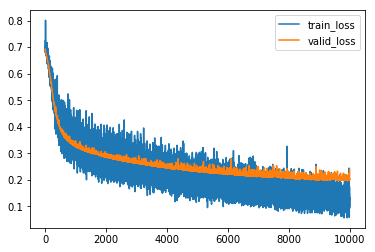

In [23]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

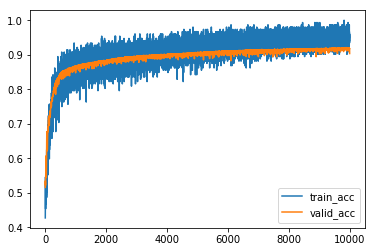

In [24]:
mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()

In [25]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    ################## Test
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_ : x, labels_ : y, keep_prob_ : 1.0}

        # Loss
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)
        acc_batch.append(acc)
        loss_batch.append(loss)

    # Store
    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints-cnn/har.ckpt
Test loss: 0.243053 Test acc: 0.905953
